In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D
import time

7.886064 6.359793
[7.886064 6.359793]


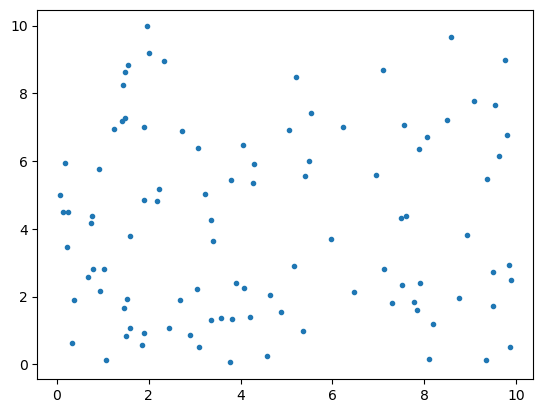

In [9]:
data = np.loadtxt('mesh.dat', skiprows= 1)
x_data = data[:,0]
y_data = data[:,1]
plt.plot(x_data, y_data, '.')
print(x_data[0], y_data[0])
print(data[0])
plt.savefig("points.png")

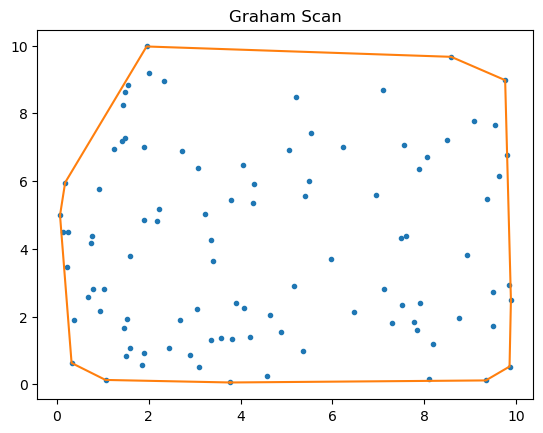

<Figure size 640x480 with 0 Axes>

In [10]:
# 2D graham scan
from math import atan2
def graham(arr):

    hull = min(arr, key=lambda point: (point[1], point[0]))

    def angle(p):
        dx, dy = p[0] - hull[0], p[1] - hull[1]
        return atan2(dy, dx)

    sorted_list = np.asarray(sorted(arr, key = lambda p: (angle(p), (p[0] - hull[0])**2 + (p[1] - hull[1])**2)))

    hull = [hull]
    def left(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0]) > 0
        
    for cords in sorted_list[1:]:
        while len(hull) > 1 and not left(hull[-2], hull[-1], cords):
            hull.pop()
        hull.append(cords)
    
    hull.append(hull[0])

    
    return np.asarray(hull)

hull = graham(data)
plt.plot(x_data, y_data, '.')
plt.plot(hull[:,0], hull[:,1])
plt.title('Graham Scan')
plt.show()
plt.savefig("grahamhull.png")

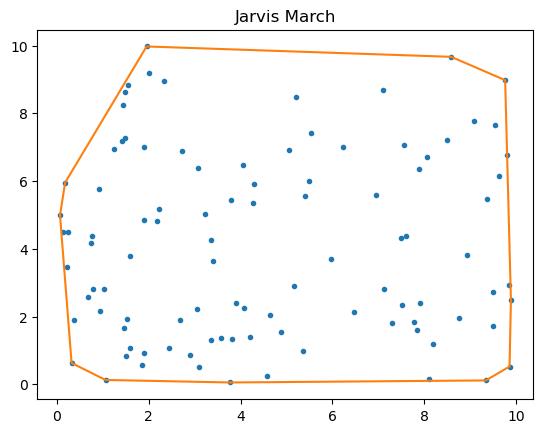

<Figure size 640x480 with 0 Axes>

In [11]:
# jarvis march
def jarvis_march(points):
    leftmost = min(points, key=lambda p: p[0])
    hull = [leftmost]

    def left(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0]) > 0
    
    current = leftmost

    while True:
        hull.append(current)
        next_point = points[0]
        for point in points:
            if point[0] == current[0] and point[1] == current[1]:
                continue
            if left(current, next_point, point):
                next_point = point
        current = next_point

        if np.all(current == leftmost):
            break
    hull.append(hull[0])

    return np.asarray(hull)

hull = jarvis_march(data)
    
plt.plot(x_data, y_data, '.')
plt.plot(hull[:,0], hull[:,1])
plt.title('Jarvis March')
plt.show()
plt.savefig("jarvishull.png")

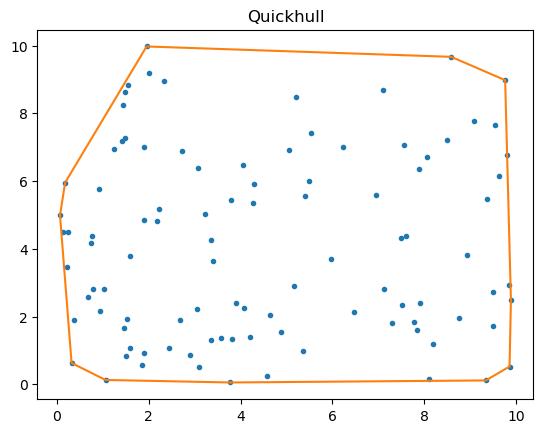

<Figure size 640x480 with 0 Axes>

In [12]:
def quickhull(points):
    def distance(p1, p2, p):
        return abs((p[1] - p1[1]) * (p2[0] - p1[0]) - (p[0] - p1[0]) * (p2[1] - p1[1]))

    def find_hull(subset, p1, p2):
        if len(subset) == 0:
            return []
        
        farthest = max(subset, key=lambda p: distance(p1, p2, p))
        subset = [p for p in subset if not np.array_equal(p, farthest)]

        left_of_farthest = [p for p in subset if is_left(p1, farthest, p)]
        right_of_farthest = [p for p in subset if is_left(farthest, p2, p)]

        return (find_hull(left_of_farthest, p1, farthest) +
                [farthest] +
                find_hull(right_of_farthest, farthest, p2))

    def is_left(p1, p2, p):
        """Check if point p is to the left of the line (p1, p2)."""
        return (p2[0] - p1[0]) * (p[1] - p1[1]) > (p[0] - p1[0]) * (p2[1] - p1[1])
    
    leftmost = points[np.argmin(points[:, 0])]
    rightmost = points[np.argmax(points[:, 0])]

    above = [p for p in points if is_left(leftmost, rightmost, p)]
    below = [p for p in points if is_left(rightmost, leftmost, p)]

    upper_hull = find_hull(above, leftmost, rightmost)
    lower_hull = find_hull(below, rightmost, leftmost)

    return np.array([leftmost] + upper_hull + [rightmost] + lower_hull + [leftmost])

hull = quickhull(data)

plt.plot(x_data, y_data, '.')
plt.plot(hull[:, 0], hull[:, 1])
plt.title("Quickhull")
plt.show()
plt.savefig("quickhull.png")


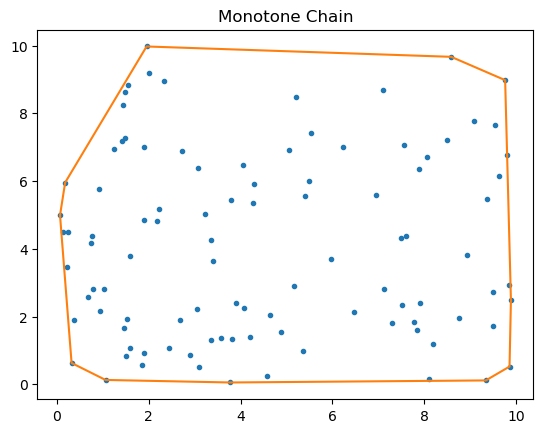

<Figure size 640x480 with 0 Axes>

In [13]:
def cross(o, a, b):
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


def monotone_chain(points):
   
    sorted_points = sorted(points, key=lambda p: (p[0], p[1]))
    
    lower = []
    for p in sorted_points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    
    upper = []
    for p in reversed(sorted_points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    
    return np.array(lower[:-1] + upper[:-1] + [lower[0]])


hull = monotone_chain(data)
plt.plot(x_data, y_data, '.')
plt.plot(hull[:, 0], hull[:, 1])
plt.title("Monotone Chain")
plt.show()
plt.savefig("monotonehull.png")

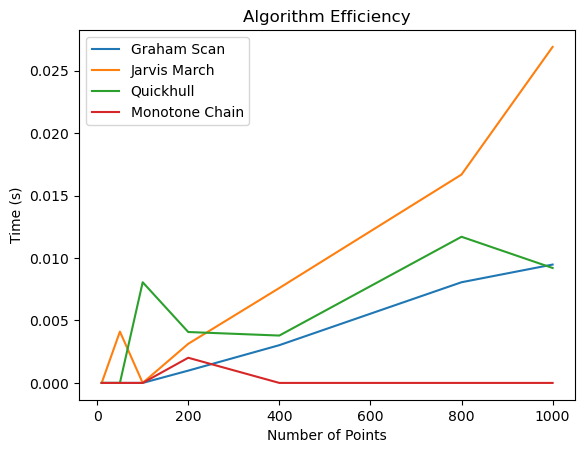

<Figure size 640x480 with 0 Axes>

In [15]:
# Sample sizes of points to test
n = [10, 50, 100, 200, 400, 800, 1000]

# Generate random point datasets
points = [np.random.rand(i, 2) for i in n]

# Initialize timing lists
graham_times = []
jarvis_times = []
quickhull_times = []
monotone_chain_times = []

# Loop through datasets
for point_set in points:
    # Graham's Scan
    start = time.time()
    try:
        graham(point_set)  # Ensure your graham() function handles all cases
    except Exception as e:
        print(f"Graham failed: {e}")
    end = time.time()
    graham_times.append(end - start)

    # Jarvis March
    start = time.time()
    try:
        jarvis_march(point_set)  # Ensure your jarvis_march() function handles all cases
    except Exception as e:
        print(f"Jarvis failed: {e}")
    end = time.time()
    jarvis_times.append(end - start)

    # Quickhull
    start = time.time()
    try:
        quickhull(point_set)  # Ensure your quickhull() function handles all cases
    except Exception as e:
        print(f"Quickhull failed: {e}")
    end = time.time()
    quickhull_times.append(end - start)

    # Monotone Chain
    start = time.time()
    try:
        monotone_chain(point_set)  # Ensure your monotone_chain() function handles all cases
    except Exception as e:
        print(f"Monotone Chain failed: {e}")
    end = time.time()
    monotone_chain_times.append(end - start)

# Plot the results
plt.plot(n, graham_times, label='Graham Scan')
plt.plot(n, jarvis_times, label='Jarvis March')
plt.plot(n, quickhull_times, label='Quickhull')
plt.plot(n, monotone_chain_times, label='Monotone Chain')
plt.legend()
plt.xlabel('Number of Points')
plt.ylabel('Time (s)')
plt.title('Algorithm Efficiency')
plt.show()
plt.savefig("time_comparison.png")


## part 2

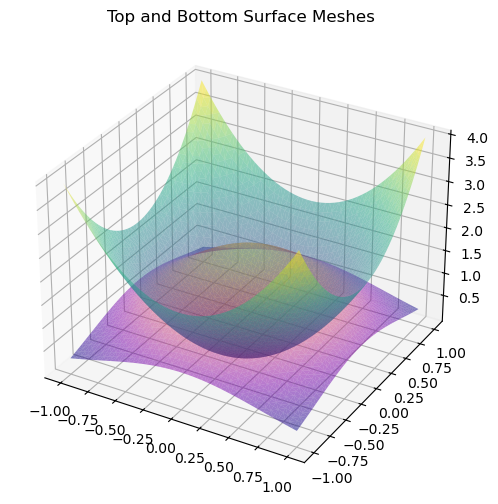

<Figure size 640x480 with 0 Axes>

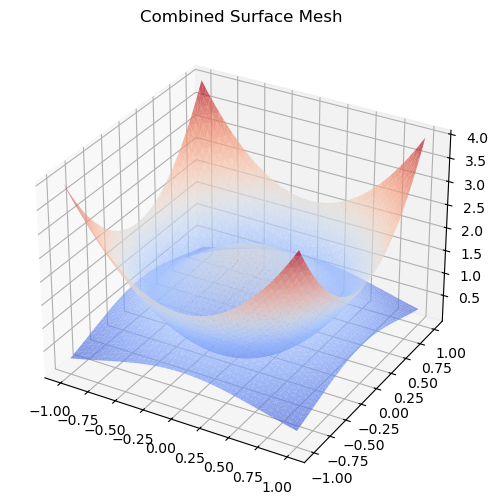

<Figure size 640x480 with 0 Axes>

In [17]:
# Define surface functions
def surface1(x, y):
    return 2 * x**2 + 2 * y**2

def surface2(x, y):
    return 2 * np.exp(-x**2 - y**2)

# Generate point cloud
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(x, y)
points_top = np.column_stack((X.ravel(), Y.ravel(), surface1(X, Y).ravel()))
points_bottom = np.column_stack((X.ravel(), Y.ravel(), surface2(X, Y).ravel()))
points = np.vstack((points_top, points_bottom))

# Perform Delaunay triangulation on top and bottom surfaces
tri_top = Delaunay(points_top[:, :2])
tri_bottom = Delaunay(points_bottom[:, :2])

# Visualization of individual meshes
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points_top[:, 0], points_top[:, 1], points_top[:, 2], triangles=tri_top.simplices, cmap='viridis', alpha=0.5)
ax.plot_trisurf(points_bottom[:, 0], points_bottom[:, 1], points_bottom[:, 2], triangles=tri_bottom.simplices, cmap='plasma', alpha=0.5)
plt.title('Top and Bottom Surface Meshes')
plt.show()
plt.savefig("topbottommesh.png")

# Combine the meshes (account for vertex id alignment)
tri_combined = np.vstack((tri_top.simplices, tri_bottom.simplices + len(points_top)))

# Visualize combined surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles=tri_combined, cmap='coolwarm', alpha=0.7)
plt.title('Combined Surface Mesh')
plt.show()
plt.savefig("combinedmesh.png")


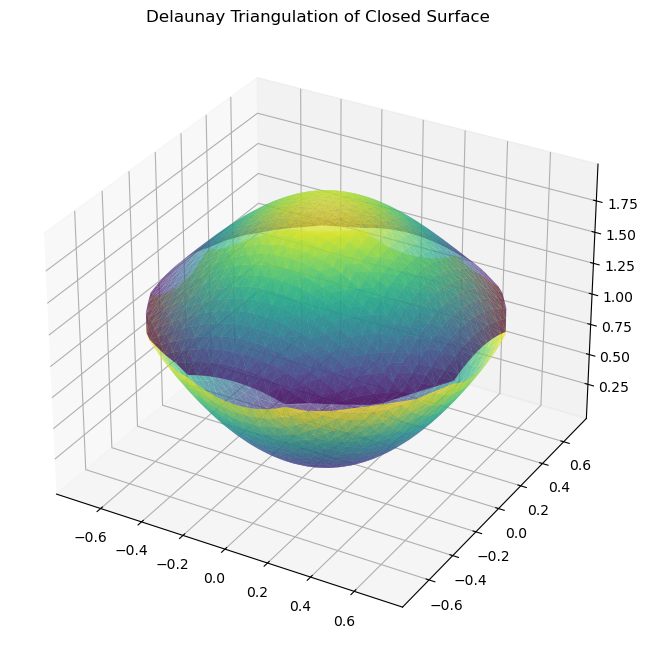

<Figure size 640x480 with 0 Axes>

In [18]:
# Generate grid points
num_points = 50
x = np.linspace(-1, 1, num_points)
y = np.linspace(-1, 1, num_points)
X, Y = np.meshgrid(x, y)

# Compute surface values
Z1 = surface1(X, Y)
Z2 = surface2(X, Y)

# Select points near the intersection
mask = Z1 <= Z2
X_filtered = X[mask]
Y_filtered = Y[mask]
Z1_filtered = Z1[mask]
Z2_filtered = Z2[mask]

# Create point clouds for top and bottom surfaces
top_points = np.column_stack((X_filtered, Y_filtered, Z1_filtered))
bottom_points = np.column_stack((X_filtered, Y_filtered, Z2_filtered))

# Perform Delaunay triangulation on the top and bottom surfaces
tri_top = Delaunay(top_points[:, :2])
tri_bottom = Delaunay(bottom_points[:, :2])

# Plot the triangulated surfaces
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot top surface
ax.plot_trisurf(top_points[:, 0], top_points[:, 1], top_points[:, 2], triangles=tri_top.simplices, cmap='viridis', alpha=0.7)

# Plot bottom surface
ax.plot_trisurf(bottom_points[:, 0], bottom_points[:, 1], bottom_points[:, 2], triangles=tri_bottom.simplices, cmap='viridis', alpha=0.7)

ax.set_title('Delaunay Triangulation of Closed Surface')
plt.show()
plt.savefig("3ddelauney.png")
